# 01 – Data Preprocessing & EDA

This notebook loads the UCI Heart Disease dataset, handles missing values, encodes categoricals, scales numerical features, and performs EDA (hist, boxplots, heatmap).


In [10]:
# --- 0. Imports ---
import pandas as pd
import numpy as np
from pathlib import Path
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler, OneHotEncoder
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
from sklearn.impute import SimpleImputer
from sklearn.decomposition import PCA
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import classification_report, confusion_matrix, roc_auc_score, roc_curve
import matplotlib.pyplot as plt


In [11]:
# --- 1. Load and prepare .data files ---
DATA_DIR = Path(r"C:\Users\Dell\Desktop\Heart_Disease_Project (1)\Heart_Disease_Project\data")
all_rows = []
for f in DATA_DIR.glob("*.data"):
    with open(f) as file:
        for line in file:
            line = line.strip()
            if line and not line.startswith("#"):
                parts = [p.strip() for p in line.split(",")]
                all_rows.append(parts)

headers = ["age","sex","cp","trestbps","chol","fbs","restecg","thalach",
           "exang","oldpeak","slope","ca","thal","num"]

df = pd.DataFrame(all_rows, columns=headers)

# Replace '?' with NaN and convert to numeric
df = df.replace("?", pd.NA)
df = df.apply(pd.to_numeric, errors='coerce')

# Drop rows with missing 'num' and create target
df = df.dropna(subset=['num'])
df['target'] = (df['num'] > 0).astype(int)
df = df.drop(columns=['num'])

print(df.shape)
print(df['target'].value_counts())
df.head()


(303, 14)
target
0    164
1    139
Name: count, dtype: int64


,age,sex,cp,trestbps,chol,fbs,restecg,thalach,exang,oldpeak,slope,ca,thal,target
0,63.0,1.0,1.0,145.0,233.0,1.0,2.0,150.0,0.0,2.3,3.0,0.0,6.0,0
1,67.0,1.0,4.0,160.0,286.0,0.0,2.0,108.0,1.0,1.5,2.0,3.0,3.0,1
2,67.0,1.0,4.0,120.0,229.0,0.0,2.0,129.0,1.0,2.6,2.0,2.0,7.0,1
3,37.0,1.0,3.0,130.0,250.0,0.0,0.0,187.0,0.0,3.5,3.0,0.0,3.0,0
4,41.0,0.0,2.0,130.0,204.0,0.0,2.0,172.0,0.0,1.4,1.0,0.0,3.0,0


In [12]:
# --- 2. Split features and labels ---
X = df.drop(columns=['target'])
y = df['target']

num_features = X.select_dtypes(include=np.number).columns.tolist()
cat_features = [c for c in X.columns if c not in num_features]

numeric_transformer = Pipeline(steps=[
    ("imputer", SimpleImputer(strategy="median")),
    ("scaler", StandardScaler())
])

categorical_transformer = Pipeline(steps=[
    ("imputer", SimpleImputer(strategy="most_frequent")),
    ("onehot", OneHotEncoder(handle_unknown="ignore"))
])

preprocessor = ColumnTransformer(
    transformers=[
        ("num", numeric_transformer, num_features),
        ("cat", categorical_transformer, cat_features)
    ]
)

X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, random_state=42, stratify=y
)

print("Train:", X_train.shape, " Test:", X_test.shape)


Train: (242, 13)  Test: (61, 13)


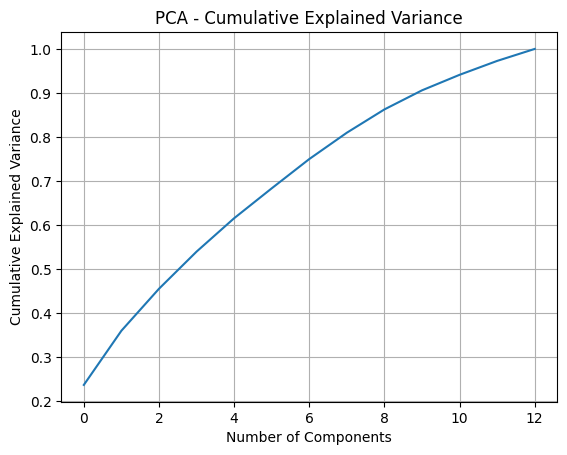

In [13]:
# --- 3. PCA Example ---
X_clean = X.replace("?", np.nan).apply(pd.to_numeric, errors='coerce')
X_clean = X_clean.fillna(X_clean.median())

X_scaled = StandardScaler().fit_transform(X_clean)
pca = PCA().fit(X_scaled)

plt.plot(np.cumsum(pca.explained_variance_ratio_))
plt.xlabel('Number of Components')
plt.ylabel('Cumulative Explained Variance')
plt.title('PCA - Cumulative Explained Variance')
plt.grid(True)
plt.show()


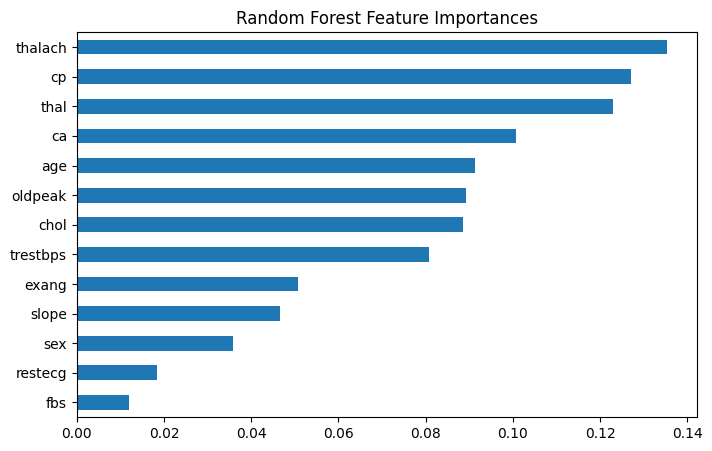

In [14]:
# --- 4. Feature Selection with Random Forest ---
# Clean training/test sets
X_train_clean = X_train.replace("?", np.nan).apply(pd.to_numeric, errors='coerce').fillna(X_train.median())
X_test_clean  = X_test.replace("?", np.nan).apply(pd.to_numeric, errors='coerce').fillna(X_test.median())

rf = RandomForestClassifier(random_state=42)
rf.fit(X_train_clean, y_train)

importances = pd.Series(rf.feature_importances_, index=X_train_clean.columns)
importances.sort_values().plot(kind='barh', figsize=(8,5))
plt.title('Random Forest Feature Importances')
plt.show()


Classification Report:
              precision    recall  f1-score   support

           0       0.93      0.85      0.89        33
           1       0.84      0.93      0.88        28

    accuracy                           0.89        61
   macro avg       0.89      0.89      0.89        61
weighted avg       0.89      0.89      0.89        61

Confusion Matrix:
 [[28  5]
 [ 2 26]]
AUC: 0.9518398268398268


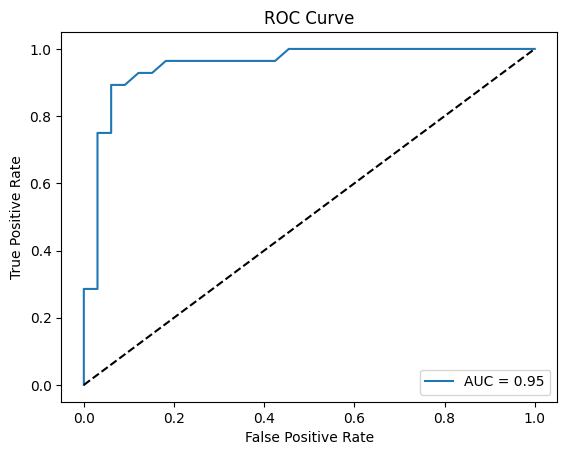

In [15]:
# --- 5. Evaluate Model ---
y_pred = rf.predict(X_test_clean)
y_prob = rf.predict_proba(X_test_clean)[:,1]

print("Classification Report:")
print(classification_report(y_test, y_pred))
print("Confusion Matrix:\n", confusion_matrix(y_test, y_pred))

auc = roc_auc_score(y_test, y_prob)
print("AUC:", auc)

fpr, tpr, _ = roc_curve(y_test, y_prob)
plt.plot(fpr, tpr, label=f"AUC = {auc:.2f}")
plt.plot([0,1],[0,1],'k--')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC Curve')
plt.legend()
plt.show()
